# Object Detection And Classification For Species Recognition

## Problem Statement

Around 12% of current bird species are considered endangered, threatened or vulnerable in some way. Many birds play a crucial roll in ecological systems for both predator and prey. Bird species such as these are known as 'keystone species' that hold an invaluable presence in their respective ecosystems. For example, a lot of birds are host to a variety of parasites and flys that also hold weight within their food chains. Additionally, many birds aid in pollination of certain plant species and creation of subhabitats such as nests or entry points in trees (woodpecker). It is incredibly important to conserve these species for both ecological and humane reasons. Not to mention, birds are peculiar and amusing to us. It would be a shame to go out on a walk and not hear the specific chirping melody based on the regional species.  
What we can do is propose a habitat protection movement. Habitat loss and destruction are one of the leading causes of bird species extinction. We can discretely place cameras in areas we know there may be endangered species and are being considered for deforestation or other means of habitat disruption. We will attempt to train our own bird detection system so that we can appropriately assess the population and activity of specific species within our geographical regions of study. Working with local governments and species conservation groups, we can present our data and work against habitat loss.

## Executive Summary

We used a combination of images from Cal-Tech's bird data set . Cal-Tech's bird data set includes 200 species of around 80 images per species. We have abridged the dataset to 3 species of around 80 images per species. The species we will be considering include a Cardinal, Black-footed Albatross, and Western Meadowlark. The intended outcome of our study is to analyze various methods of segmentation and object detection, as opposed to produced a highly accurate bird classification model (although we will include classification). Image segmentation allows us to extract and separate different regions within our image. We are going to apply a selective search approach. We will then apply and evaluate a Convolutional Neural Network that will help us determine which segments are of interest (bird) and which are not (background noise, other animals,..so on)



Selective Search
- Diverse application of grouping/segmentation algorithms based on color/texture/shape  
- Proposes multiple regions of interest  
- Heirarchical 


As with many image recognition and object detection problems, we run into many recurrent and expected problems. We must consider how we will account for birds with different poses, facing different directions, leaning forwards or backwards, facing the camera or facing away, flying or standing, and so on. If we feed in images of birds in only certain poses, lets say all facing left, how will our detection system recognize a bird facing right. We also have to considered different background classes. Different bird species will habit different genres of terrain(what region are these species found in), and similarly we have to account for what season it is, weather conditions, time of day, lighting, etc.. We have accounted for some of these issues with data augmentation where we have generated copies of our original data with added noise that can be considered synonymous with camera inconsistencies (scratching,dust) and orientation flips (pose left,right). Our augmentation was minimal given time constraints and annotations, so we are avoiding rotation.

For both approaches, we fit and evaluated various classification algorithms in a binary setting (foreground,background). We use our annotated boundary boxes on our birds so we can retrieve suggested candidate regions for foreground objects. We calculated an Intersection over Union score (IoU) to determine how overlapped our proposed regions by our segmentation are with our ground truth (annoted labels) box. Regions with a score greater than 0.7 would be classified as foreground and regions with a score less than 0.3 would be classified as background. Scores between 0.7 and 0.3 are ignored. Our classification model consists out a multi layer Convalutional Network connected to a Fully Connected layer.

## Data Dictionary

| Name| Data Types (Pandas) | Description |
|---|---|---|
|root|object|root file path of image|
|filename|object|full filename plus doc ext of image file|
|w|int64|width of image|
|h|int64|height of image|
|x1|int64|first x-coordinate of bounding box|
|y1|int64|first y-coordinate of bounding box|
|x2|int64|second x-coordinate of bounding box|
|y2|int64|second y-coordinate of bounding box|


In [6]:
import tensorflow as tf
import IPython.display as display

In [7]:

import base64
from PIL import Image
import io

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11545686798054790980
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4237831889064666947
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input
from keras.callbacks import EarlyStopping

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input

import cv2

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, auc
from sklearn.preprocessing import LabelBinarizer

import xml.etree.ElementTree as ET


In [10]:
#load data with pandas
train_path='./data/bird2_train/'
test_path='./data/bird2_test/'

## Read in CVAT annotion file with XML parser

We performed annotations (labeled boundary boxes) on our images around birds so we can set up an object detection model. These annotations were performed in Computer Vision Annotation Tool (CVAT). CVAT spits out an XML containing our image metadata, such as heigh, width, boundary box coordinate, and so on. We will parse through this XML with xml tree and create our initial dataframe.

In [11]:
def create_df_xml(input1):
    annotation=ET.parse(f'./data/bird2_{input1}/{input1}_annotations.xml')
    root=annotation.getroot()
    df_cols=['root','filename','w','h']
    df_rows=[]
    for node in root.iter('image'):
        #print (list(node.attrib.values()))
        s_root=f'/data/bird2_{input1}/'
        s_name=list(node.attrib.values())[1]
        s_height=list(node.attrib.values())[3]
        s_width=list(node.attrib.values())[2]
         
        
    
        df_rows.append({'root':s_root,'filename': s_name,'w':s_width,'h':s_height,
                            })
        x1=pd.DataFrame(df_rows, columns = df_cols)
    df_cols=['x1','x2','y1','y2']
    df_rows=[]
    for node in root.iter('image'):
        for node1 in node:
            s_x1=list(node1.attrib.values())[2]
            s_x2=list(node1.attrib.values())[4]
            s_y1=list(node1.attrib.values())[3]
            s_y2=list(node1.attrib.values())[5]
   
            df_rows.append({
                            'x1':s_x1,'x2':s_x2,'y1':s_y1,'y2':s_y2})
        x2=pd.DataFrame(df_rows,columns=df_cols)
    x4= pd.concat((x1,x2),axis=1)    
    return x4

In [12]:
#apply to test and train sets
test1=create_df_xml('test')
train1=create_df_xml('train')

In [13]:
#lets get a look at our data
train1.head()

,root,filename,w,h,x1,x2,y1,y2
0,/data/bird2_train/,70095201-480px.jpg,480,360,6.72,422.55,67.11,308.78
1,/data/bird2_train/,Black_Footed_Albatross_0002_55.jpg,500,347,12.04,403.98,109.90,298.88
2,/data/bird2_train/,Black_Footed_Albatross_0042_796071.jpg,500,356,134.72,442.23,82.85,261.11
3,/data/bird2_train/,Black_Footed_Albatross_0051_796103.jpg,500,391,79.58,411.60,88.58,238.16
4,/data/bird2_train/,Black_Footed_Albatross_0056_796078.jpg,500,390,147.48,345.61,88.37,259.90


In [14]:
test1.head()

,root,filename,w,h,x1,x2,y1,y2
0,/data/bird2_test/,Black_Footed_Albatross_0033_796086.jpg,500,375,36.18,440.24,62.17,238.15
1,/data/bird2_test/,Black_Footed_Albatross_0038_212.jpg,500,332,134.41,429.68,61.48,223.27
2,/data/bird2_test/,Black_Footed_Albatross_0039_796132.jpg,500,500,150.79,460.31,151.71,354.56
3,/data/bird2_test/,Black_Footed_Albatross_0057_796106.jpg,500,337,69.41,362.56,40.22,266.45
4,/data/bird2_test/,Black_Footed_Albatross_0063_796141.jpg,288,192,47.44,243.70,26.67,140.82


In [15]:
#some quick conversions
train1['w']=train1['w'].astype(int)
train1['h']=train1['h'].astype(int)
train1['x1']=train1['x1'].astype(float).round().astype(int)
train1['x2']=train1['x2'].astype(float).round().astype(int)
train1['y1']=train1['y1'].astype(float).round().astype(int)
train1['y2']=train1['y2'].astype(float).round().astype(int)

In [16]:
test1['w']=test1['w'].astype(int)
test1['h']=test1['h'].astype(int)
test1['x1']=test1['x1'].astype(float).round().astype(int)
test1['x2']=test1['x2'].astype(float).round().astype(int)
test1['y1']=test1['y1'].astype(float).round().astype(int)
test1['y2']=test1['y2'].astype(float).round().astype(int)

## Image Augmentation

Augmentation is different from preprocessing in the sense that it is only applied on our training data. It is used to make our data more robust so we can account for a broader variety of image classes. 

### Read in TF Record from Roboflow.ai

Roboflow is an online augmentation platform that allows us to perform augmentations on our image that will also be applied to our annotations. We uploaded our images and their associated annotations and applied several augmentations per image including: random rotation, horizontal flip, noise generation, and brightness adjustment. We then generate a TFRecord from 

In [17]:
# followed TF documentation https://www.tensorflow.org/tutorials/load_data/tfrecord
raw_image_dataset = tf.data.TFRecordDataset('./data/train/birds.tfrecord')

In [18]:
image_feature_description = {
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/xmax':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymax':tf.io.FixedLenFeature([], tf.float32)

}

In [19]:
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/encoded: (), image/filename: (), image/height: (), image/object/bbox/xmax: (), image/object/bbox/xmin: (), image/object/bbox/ymax: (), image/object/bbox/ymin: (), image/width: ()}, types: {image/encoded: tf.string, image/filename: tf.string, image/height: tf.int64, image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/width: tf.int64}>

In [20]:

df_cols=['root','filename','w','h','x1','x2','y1','y2']
df_rows=[]

for i,image_features in enumerate(parsed_image_dataset):
    
    ##grab data from our parsed TFRecord file
    s_root='/data/bird2_train/'
    image_raw = image_features['image/encoded'].numpy()
    image_height=image_features['image/height'].numpy()
    image_width=image_features['image/width'].numpy()
    image_x1=int(round(image_features['image/object/bbox/xmin'].numpy()*image_width))
    image_x2=int(round(image_features['image/object/bbox/xmax'].numpy()*image_width))
    image_y1=int(round(image_features['image/object/bbox/ymin'].numpy()*image_height))
    image_y2=int(round(image_features['image/object/bbox/ymax'].numpy()*image_height))
    filename=str(image_features['image/filename'].numpy())
    ##extract filename
    start = "b'"
    end = ".rf"
    s = filename
    filename=s[s.find(start)+len(start):s.rfind(end)]
    
    #write out and save image to our training folder
    image = Image.open(io.BytesIO(image_raw))
    image.save(f'./data/bird2_train/{filename}_{i}'+'.jpg', 'jpeg')
    filename=f'{filename}_{i}'
    #put data into dataframe
    df_rows.append({'root':s_root,'filename':filename+'.jpg','w':image_width,'h':image_height,'x1':image_x1,'x2':image_x2,
                    'y1':image_y1,'y2':image_y2
                            })
x4=pd.DataFrame(df_rows, columns = df_cols)


In [21]:
x4

,root,filename,w,h,x1,x2,y1,y2
0,/data/bird2_train/,Western_Meadowlark_0048_78354_jpg_0.jpg,332,500,18,255,110,371
1,/data/bird2_train/,Western_Meadowlark_0112_78760_jpg_1.jpg,500,400,133,384,0,295
2,/data/bird2_train/,Western_Meadowlark_0091_78576_jpg_2.jpg,500,386,113,403,69,278
3,/data/bird2_train/,Black_Footed_Albatross_0060_796076_jpg_3.jpg,320,240,17,312,52,229
4,/data/bird2_train/,Cardinal_0075_17946_jpg_4.jpg,399,500,132,301,141,339
...,...,...,...,...,...,...,...,...
241,/data/bird2_train/,Western_Meadowlark_0048_78354_jpg_241.jpg,332,500,32,248,110,354
242,/data/bird2_train/,Cardinal_0079_19044_jpg_242.jpg,500,346,235,367,57,201
243,/data/bird2_train/,Black_Footed_Albatross_0042_796071_jpg_243.jpg,500,356,55,382,47,280
244,/data/bird2_train/,Black_Footed_Albatross_0056_796078_jpg_244.jpg,500,390,171,349,115,254


#### Brightness

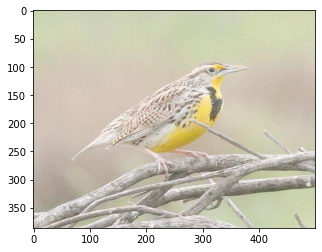

In [22]:
image = cv2.imread('.'+x4['root'][17]+x4['filename'][17])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#### Random Rotation

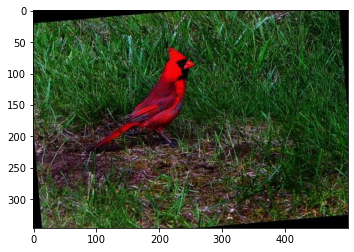

In [23]:
image = cv2.imread('.'+x4['root'][26]+x4['filename'][26])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#### Noise + Rotation

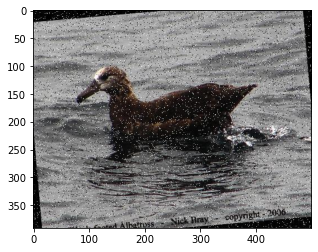

In [24]:
image = cv2.imread('.'+x4['root'][47]+x4['filename'][47])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [25]:
train2=pd.concat((train1,x4),ignore_index=True)

In [26]:
train2.head(15)

,root,filename,w,h,x1,x2,y1,y2
0,/data/bird2_train/,70095201-480px.jpg,480,360,7,423,67,309
1,/data/bird2_train/,Black_Footed_Albatross_0002_55.jpg,500,347,12,404,110,299
2,/data/bird2_train/,Black_Footed_Albatross_0042_796071.jpg,500,356,135,442,83,261
3,/data/bird2_train/,Black_Footed_Albatross_0051_796103.jpg,500,391,80,412,89,238
4,/data/bird2_train/,Black_Footed_Albatross_0056_796078.jpg,500,390,147,346,88,260
5,/data/bird2_train/,Black_Footed_Albatross_0060_796076.jpg,320,240,11,292,78,211
6,/data/bird2_train/,Black_Footed_Albatross_0061_796082.jpg,240,187,50,209,25,162
7,/data/bird2_train/,Black_Footed_Albatross_0076_417.jpg,500,441,74,426,115,324
8,/data/bird2_train/,Black_Footed_Albatross_0081_426.jpg,500,320,94,357,75,250
9,/data/bird2_train/,Cardinal_0051_17223.jpg,500,421,11,189,191,408


## Ground truth boxes 

In [27]:
train2['filename'][5]

'Black_Footed_Albatross_0060_796076.jpg'

In [28]:
'.'+train2['root'][5]+train2['filename'][5]

'./data/bird2_train/Black_Footed_Albatross_0060_796076.jpg'

In [29]:
def bbox_plot(i):

    image = cv2.imread('.'+train2['root'][i]+train2['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=train2['x1'][i]
    x2=train2['x2'][i]
    y1=train2['y1'][i]
    y2=train2['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

In [30]:
def bbox_plot1(i):

    image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=test1['x1'][i]
    x2=test1['x2'][i]
    y1=test1['y1'][i]
    y2=test1['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

133 384 0 295


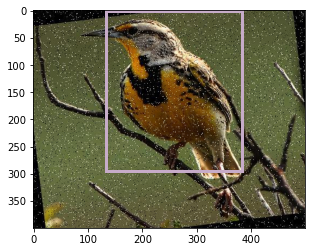

In [31]:
bbox_plot(43)

293 438 77 327


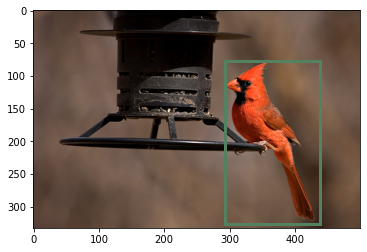

In [32]:
bbox_plot(13)

## Region Proposal System

In [33]:
#https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
#https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

In [34]:
#http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

We're going to be using OpenCVs selective search segmentation algorithm. Please refer to the above paper if you would like a more in depth look of how Selective Search was built off its predecessors. In general, Selective Search applies a wide variety of algorithms on multiples scales and looks to segment out images. The segmentations are based on region characteristics and similarities in color,texture, and size. OpenCVs method of segmentations returns the coordinates for us in a bounding box format.

### Segmentation Examples

In [35]:
#read in our image and convert to color
image = cv2.imread('.'+test1['root'][13]+test1['filename'][13])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

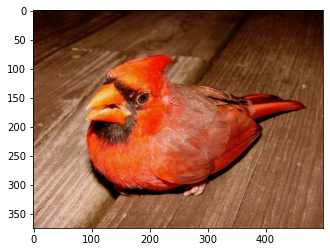

In [36]:
plt.imshow(image)

Basic color image of our cardinal we want to segment.

In [37]:
cv2.setUseOptimized(True)

In [38]:
##Initiate Segmentation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
##Set base image to our specific ingest image
ss.setBaseImage(image)

In [39]:
%%time
##Selecting Quality Search over Fast, lower recall rate but higher rate of proposals
##(refer to #http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)
ss.switchToSelectiveSearchQuality()
##Process our image
rects = ss.process()
print(f'we have {len(rects)} proposals')

we have 1861 proposals
Wall time: 6.88 s


In [40]:
rects[:5]

array([[ 94, 138, 291, 170],
       [384, 217,  70, 158],
       [ 29, 289, 100,  86],
       [104, 266,  29,  28],
       [ 94, 191,  64,  58]], dtype=int32)

As we see above, ss.process() returns x1,y1, w,h coordinates of its segmented regions. Lets display the top 200 proposals from our algorithm.

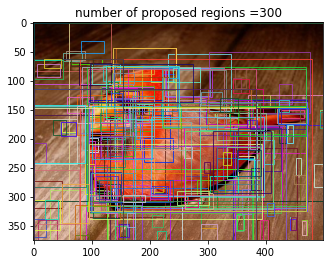

In [41]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=300
#loop through proposal coordinates
for i, rect in enumerate(rects):
    #for proposal count less than our threshold, display these proposals on our image
    if (i < t1):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')
    
plt.imshow(imOut)

One of our cardinal images that has been segmented with Quality Segmentation. Top 300 Regions.

In [42]:
image = cv2.imread('.'+test1['root'][19]+test1['filename'][19])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
print(f'we have {len(rects)} proposals')


we have 1649 proposals


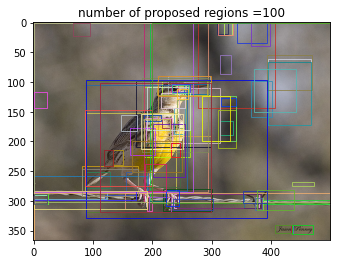

In [43]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=100
for i, rect in enumerate(rects):
    if (i < t1):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')

        
plt.imshow(imOut)

## Calculate Intersection over Unioin

In [44]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

The IoU is a ratio or 'score' associating how overlapped the proposed regions with our ground truth boxes. This is a common technique in pretty much every version of region-based CNNs. A score of 1 is one box totally overlaps the other, and 0 is there is no overlap. For our boundary box regression? problem, we will assign 1 to regions with a score of over 0.7 and 0 to regions with an IoU score of 0.3 and assignt nothing to those inbetween. We will also pass along our strong iou score windows for Feature Mapping(CNN).

The thing is smaller boxes still totally INSIDE the ground truth box will stll have LOW scores if they are way smaller than the ground truth box ...consider this.

In [45]:
def calc_iou(box1,box2):
   
    left_max=max(box1['x1'],box2['x1'])
    right_min=min(box1['x2'],box2['x2'])
    top_min=min(box1['y2'],box2['y2'])
    bottom_max=max(box1['y1'],box2['y1'])
    
    area_of_intersect=(right_min-left_max)*(top_min-bottom_max)
    area_of_union=((box1['y2']-box1['y1'])*(box1['x2']-box1['x1']))+((box2['y2']-box2['y1'])*(box2['x2']-box2['x1']))-area_of_intersect
    iou=(area_of_intersect)/(area_of_union)

    return iou

Were going to loop through each image, get the ground truth box, run segmentation, utilize our IoU function, label regions with 1 for high iou and 0 for low iou and save all to list. We then do a binary classification problem on these regions 

### High IoU Score Examples

In [46]:
image = cv2.imread('.'+train1['root'][0]+train1['filename'][0])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
#rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [47]:
len(rects)

2097

In [48]:
box1={}
box1['x1']=round(float(train1['x1'][0]))
box1['x2']=round(float(train1['x2'][0]))
box1['y1']=round(float(train1['y1'][0]))
box1['y2']=round(float(train1['y2'][0]))

Text(0.5, 1.0, '74 Regions w. IoU > 0.7')

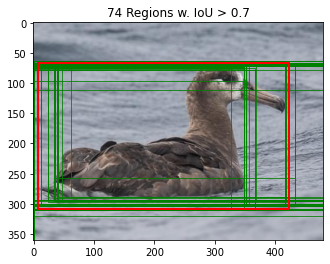

In [49]:
fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

Red box is our ground truth box. Green boxes are segmentations with IoU score > 0.7

In [50]:
image = cv2.imread('.'+train1['root'][15]+train1['filename'][15])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
len(rects)
box1={}
box1['x1']=round(float(train1['x1'][15]))
box1['x2']=round(float(train1['x2'][15]))
box1['y1']=round(float(train1['y1'][15]))
box1['y2']=round(float(train1['y2'][15]))

Text(0.5, 1.0, '108 Regions w. IoU > 0.7')

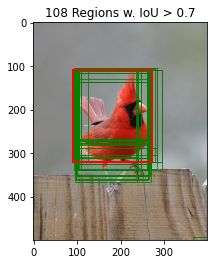

In [51]:
fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

## Model Setup

#### WARNING Long Process time. Preforming segmentation on our training data set.

This tidbit of code will set up our binary classifier data but cropping out all the segments with greater than 0.7 IoU score, resizing them all to same size (need to do this to fit a model) and then appending them to our data set with a label of 1 for >0.7 IoU or 0 for <0.3 IoU score. We will disregard regions in between.

In [52]:
#Initiate training data set
train_images=[]
train_labels=[]

In [53]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

FIND AND REPLACE TRAIN2 OR TRAIN1 to use augmented or unaugmented data, respectively.

In [54]:
##code adopted from 
##https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

#loop through our dataframe and get our image filenames to read in
for i,item in enumerate(train1['filename']):
    try:
        #get our ground truth box
        box1={}
        box1['x1']=round(float(train1['x1'][i]))
        box1['x2']=round(float(train1['x2'][i]))
        box1['y1']=round(float(train1['y1'][i]))
        box1['y2']=round(float(train1['y2'][i]))
        
        
        #read in image
        image = cv2.imread('.'+train1['root'][i]+train1['filename'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #run selective search
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        #apply filters
#        rects = list(filter(lambda x : x[2]<x[3]*10 and x[3]<x[2]*10, rects))
#         if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#             rects = list(filter(lambda x : x[2]>x[3], rects))
#         else:
#             rects = list(filter(lambda x : x[2]<=x[3], rects))
    
#         rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
        
        imout=image.copy()
        
        #we want to set some limits to the number of classes we assign per image
        #we dont want to have unbalanced classes so we set a limit of 30 regions per image per label
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        ##loop through proposed regions
        for j,item in enumerate(rects):
            #get top 2000 regions
            if j<2000 and flag==0:
                #assign proposed region coordinates to coordinate dictionary, similiar to our ground truth box.
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                #calculate IoU score of ground truth with proposal
                iou_score=calc_iou(box1,box3)
                #check to make sure there are less than 40 positive classes for this image
                if counter1<40:
                    #if IoU score is high, greater than 0.7 lets assign it to positive class 1
                    if iou_score>0.7:
                        #crop out proposal
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        #resize for model input resampling using pixel area relation
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        #add image data to our train set
                        train_images.append(resized)
                        #append positive class
                        train_labels.append(1)
                        #increment counter
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<40:
                    #if iou_score is low, less than 0.3 lets assign it to negative class 0
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
            #If we have 70 regions for botch classes within the image, we move on        
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
            
            
            
    
            
        

In [55]:
print(len(train_images))
print(len(train_labels))

2644
2644


In [56]:
count=0
for i in train_labels:
    if i==1:
        count+=1
print(count)

964


### Preform same steps on test data

We will preform the exact same preprocessing steps to our test data, refer to above cells.

In [57]:
test_images=[]
test_labels=[]

In [58]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [59]:
for i,item in enumerate(test1['filename']):
    try:

        box1={}
        box1['x1']=round(float(test1['x1'][i]))
        box1['x2']=round(float(test1['x2'][i]))
        box1['y1']=round(float(test1['y1'][i]))
        box1['y2']=round(float(test1['y2'][i]))
        
        
        
        image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ss.setBaseImage(image)

        
        ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        imout=image.copy()
        
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        for j,item in enumerate(rects):
            if j<2000 and flag==0:
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                iou_score=calc_iou(box1,box3)
                if counter1<30:
                    if iou_score>0.7:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(1)
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<30:
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
                    
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
            
    

### Positive sample

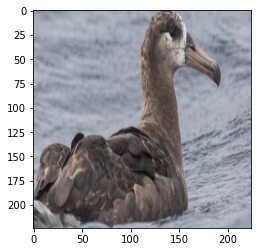

In [90]:
for i,(image,label) in enumerate(zip(train_images,train_labels)):
    if label==1:
        plt.imshow(image)
        break

### Negative sample

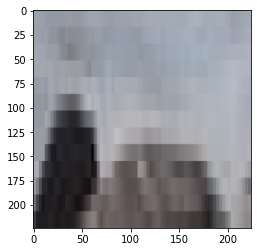

In [91]:
for i,(image,label) in enumerate(zip(train_images,train_labels)):
    if label==0:
        plt.imshow(image)
        break

## Modeling

### Baseline

First, let us determine a baseline accuracy score to compare against. Since we are doing a binary classification model, our baseline should be .50

In [60]:
print(len(test_images))
print(len(test_labels))

1259
1259


In [61]:
count=0
for i in test_labels:
    if i==1:
        count+=1
print(count)

509


In [62]:
X_train=np.array(train_images)

In [63]:
X_train.shape

(2644, 224, 224, 3)

In [64]:
y_train=np.array(train_labels)

In [65]:
X_test=np.array(test_images)

In [66]:
y_test=np.array(test_labels)

In [67]:
X_test.shape

(1259, 224, 224, 3)

## Binary Classifier with CNN

In [68]:
X_train.shape

(2644, 224, 224, 3)

In [69]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3),input_shape=(224,224,3), activation='relu'))
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [70]:
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(128, (3, 3), activation='relu'))
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(128, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [71]:
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(256, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [72]:
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [73]:
cnn.add(Conv2D(256, (3, 3), activation='relu'))
#cnn.add(ZeroPadding2D((1,1)))
cnn.add(Conv2D(256, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [74]:
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(512, (3, 3), activation='relu'))
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(512, (3, 3), activation='relu'))
# cnn.add(ZeroPadding2D((1,1)))
# cnn.add(Conv2D(512, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D((2,2), strides=(2,2)))

In [75]:
cnn.add(Flatten())


In [76]:
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))
#cnn.add(Dense(500, activation='softmax'))

In [77]:
#cnn.add(Dense(2,activation='softmax'))

In [78]:
cnn.add(Dense(1,activation='sigmoid'))


In [79]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [80]:
early_stop=EarlyStopping(monitor='val_binary_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')

In [81]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 128)       7

In [82]:
history = cnn.fit(X_train,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=20,
                        verbose=1,callbacks=[early_stop])

Train on 2644 samples, validate on 1259 samples
Epoch 1/20
2644/2644 [==============================] - 35s 13ms/sample - loss: 0.9576 - binary_accuracy: 0.6808 - val_loss: 0.6088 - val_binary_accuracy: 0.6521
Epoch 2/20
2644/2644 [==============================] - 26s 10ms/sample - loss: 0.4568 - binary_accuracy: 0.8033 - val_loss: 0.3887 - val_binary_accuracy: 0.8499
Epoch 3/20
2644/2644 [==============================] - 26s 10ms/sample - loss: 0.3525 - binary_accuracy: 0.8756 - val_loss: 0.3645 - val_binary_accuracy: 0.8626
Epoch 4/20
2644/2644 [==============================] - 26s 10ms/sample - loss: 0.2984 - binary_accuracy: 0.9024 - val_loss: 0.3264 - val_binary_accuracy: 0.8840
Epoch 5/20
2644/2644 [==============================] - 26s 10ms/sample - loss: 0.2461 - binary_accuracy: 0.9236 - val_loss: 0.3661 - val_binary_accuracy: 0.8809
Epoch 6/20
2644/2644 [==============================] - 26s 10ms/sample - loss: 0.2411 - binary_accuracy: 0.9225 - val_loss: 0.3421 - val_bina

## Results & Evaluation

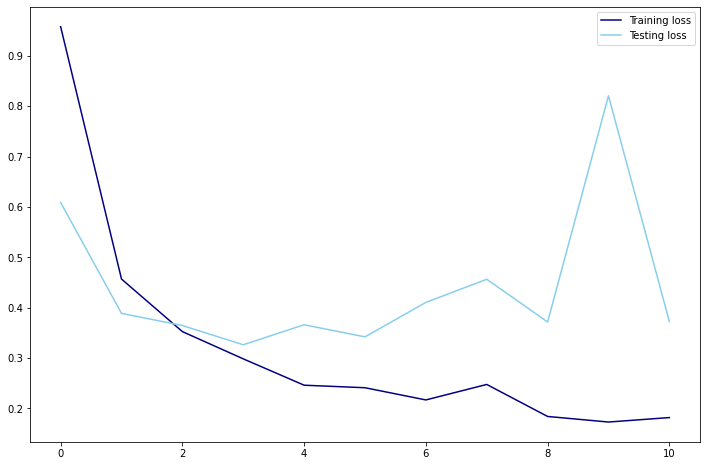

In [83]:
train_loss=history.history['loss']
test_loss=history.history['val_loss']
plt.figure(figsize=(12,8))
plt.plot(train_loss,label='Training loss', color='navy')
plt.plot(test_loss,label='Testing loss',color='skyblue')
plt.legend();

As we can see from our loss graph above, our model is somewhat overfit with testing loss increasing sightly as train loss decreases. We can combat overfitting by applying more augmentations, more regularization, or simplifying our model.

In [ ]:
# pred = model1.predict(test_matrix)
# cm=metrics.confusion_matrix(test_labels,pred)
# print(cm)
# plt.imshow(cm, cmap='binary')

In [92]:
preds=cnn.predict(X_test)

In [93]:
preds[:5]

array([[0.10559373],
       [0.10559373],
       [0.07789172],
       [0.10559373],
       [0.10559373]], dtype=float32)

In [94]:
test2=pd.DataFrame(y_test)

In [95]:
preds=pd.DataFrame(preds)

In [96]:
x=pd.concat((preds,test2),axis=1,ignore_index=False)

In [97]:
x.columns = ['pbird','isbird']

### True Positives

In [98]:
x[(x['pbird']>0.5)&(x['isbird']==1)].head()

,pbird,isbird
88,0.627931,1
91,0.515996,1
93,0.732286,1
94,0.719646,1
95,0.640263,1


In [99]:
TP=x[(x['pbird']>0.5)&(x['isbird']==1)].shape[0]
TP

Correct positive predictions

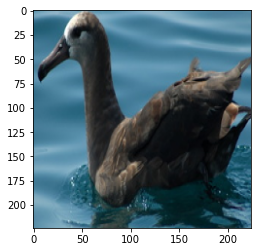

In [139]:
plt.imshow(X_test[88])

### True Negatives

In [100]:
x[(x['pbird']<0.5)&(x['isbird']==0)].head()

,pbird,isbird
0,0.105594,0
1,0.105594,0
2,0.077892,0
3,0.105594,0
4,0.105594,0


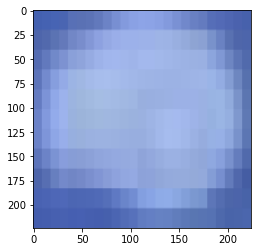

In [138]:
plt.imshow(X_test[4])

In [2]:
TN=x[(x['pbird']<0.5)&(x['isbird']==0)].shape[0]
print(TN)

NameError: name 'x' is not defined

### False Positives

In [102]:
x[(x['pbird']>0.5)&(x['isbird']==0)].head()

,pbird,isbird
374,0.506449,0
384,0.501815,0
396,0.523293,0
424,0.767657,0
628,0.697410,0


In [103]:
FP=x[(x['pbird']>0.5)&(x['isbird']==0)].shape[0]
FP

Predicted as bird but is background

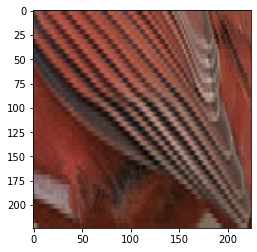

In [136]:
plt.imshow(X_test[396])

### False Negatives

In [104]:
x[(x['pbird']<0.5)&(x['isbird']==1)].head()


,pbird,isbird
30,0.067970,1
31,0.064896,1
32,0.084906,1
33,0.069622,1
34,0.070545,1


In [105]:
FN=x[(x['pbird']<0.5)&(x['isbird']==1)].shape[0]
FN

Being predicted as background but is foreground.

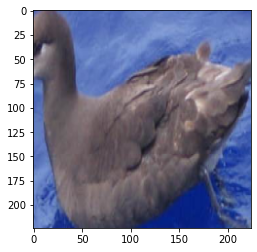

In [135]:
plt.imshow(X_test[31])

## Confusion Matrix

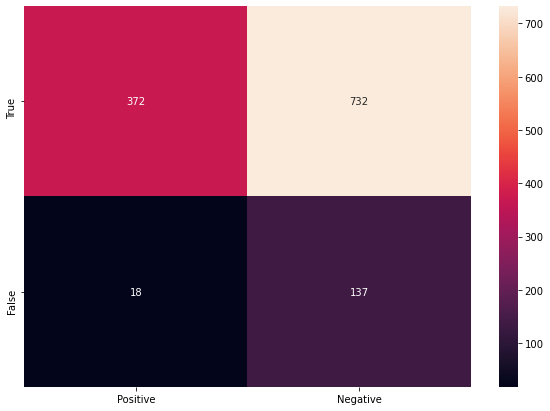

In [106]:
array = [[TP,TN],
        [FP,FN]]
df_cm = pd.DataFrame(array, index = ['True','False'],
                  columns = ['Positive','Negative'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='1g')

In [107]:
im=X_test[0]

In [108]:
y_test[43]

1

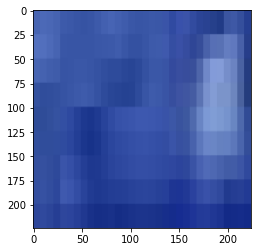

In [109]:
plt.imshow(im)

## Deployment

In [ ]:
#https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [ ]:
#https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506

In [410]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [467]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][16])

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

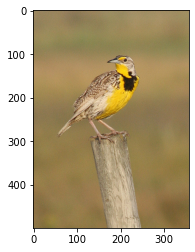

In [468]:
plt.imshow(image)

In [469]:
ss.setBaseImage(image)
        
ss.switchToSelectiveSearchQuality()
rects = ss.process()
rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [470]:
rects[:10]

[array([201, 141,  37,  45], dtype=int32),
 array([  0,   0, 357, 500], dtype=int32),
 array([223, 153,  15,  35], dtype=int32),
 array([155, 294,  31,  12], dtype=int32),
 array([ 51, 246,  58,  48], dtype=int32),
 array([183, 135,  30,  20], dtype=int32),
 array([114, 239,  44,  51], dtype=int32),
 array([119, 215,  21,  20], dtype=int32),
 array([ 52, 230,  69,  64], dtype=int32),
 array([ 54, 103, 192, 205], dtype=int32)]

In [471]:
image.shape

(500, 357, 3)

In [472]:
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<500:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)

In [473]:
test_sample_array=np.array(test_sample)

In [474]:
test_sample_array.shape

(500, 224, 224, 3)

In [475]:
# nsamples,nx,ny,c=test_sample_array.shape
# test_sample_array=test_sample_array.reshape((nsamples,nx*ny,c))

In [476]:
test_sample_array.shape

(500, 224, 224, 3)

In [477]:
test_sample_preds=cnn.predict(test_sample_array)

In [478]:
test_sample_preds[:5]

array([[0.0388205 ],
       [0.6695738 ],
       [0.04072661],
       [0.04584367],
       [0.05259675]], dtype=float32)

In [492]:
fore=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.7:
        fore.append(sample)

In [493]:
fore

[array([ 54, 103, 192, 205], dtype=int32),
 array([ 51, 149, 195, 145], dtype=int32),
 array([ 84, 153, 158, 139], dtype=int32),
 array([ 52, 124, 190, 183], dtype=int32),
 array([ 52, 103, 194, 205], dtype=int32),
 array([ 51, 103, 195, 195], dtype=int32),
 array([ 52, 103, 194, 204], dtype=int32),
 array([ 51, 136, 149, 158], dtype=int32),
 array([ 51, 103, 195, 204], dtype=int32),
 array([ 52, 152, 189, 142], dtype=int32),
 array([ 88, 114, 121, 122], dtype=int32),
 array([ 83, 149, 163, 142], dtype=int32),
 array([ 52, 103, 194, 197], dtype=int32),
 array([ 51, 136, 141, 158], dtype=int32),
 array([101, 150, 141, 100], dtype=int32),
 array([ 51, 108, 177, 220], dtype=int32),
 array([ 55, 138, 190, 169], dtype=int32),
 array([ 55, 138, 147, 155], dtype=int32),
 array([ 51, 103, 195, 191], dtype=int32),
 array([ 55, 138, 190, 170], dtype=int32),
 array([ 52, 124, 190, 260], dtype=int32),
 array([ 82, 136, 113, 118], dtype=int32),
 array([ 92, 212, 108,  83], dtype=int32),
 array([ 51

In [494]:
image = cv2.imread('.'+test1['root'][13]+test1['filename'][16])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

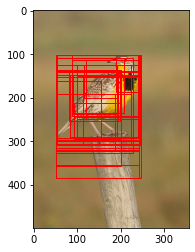

In [495]:
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)

In [496]:
fore[:6]

[array([ 54, 103, 192, 205], dtype=int32),
 array([ 51, 149, 195, 145], dtype=int32),
 array([ 84, 153, 158, 139], dtype=int32),
 array([ 52, 124, 190, 183], dtype=int32),
 array([ 52, 103, 194, 205], dtype=int32),
 array([ 51, 103, 195, 195], dtype=int32)]

In [497]:
myarray = np.asarray(fore)

In [498]:
myarray

array([[ 54, 103, 192, 205],
       [ 51, 149, 195, 145],
       [ 84, 153, 158, 139],
       [ 52, 124, 190, 183],
       [ 52, 103, 194, 205],
       [ 51, 103, 195, 195],
       [ 52, 103, 194, 204],
       [ 51, 136, 149, 158],
       [ 51, 103, 195, 204],
       [ 52, 152, 189, 142],
       [ 88, 114, 121, 122],
       [ 83, 149, 163, 142],
       [ 52, 103, 194, 197],
       [ 51, 136, 141, 158],
       [101, 150, 141, 100],
       [ 51, 108, 177, 220],
       [ 55, 138, 190, 169],
       [ 55, 138, 147, 155],
       [ 51, 103, 195, 191],
       [ 55, 138, 190, 170],
       [ 52, 124, 190, 260],
       [ 82, 136, 113, 118],
       [ 92, 212, 108,  83],
       [ 51, 103, 195, 205],
       [ 51, 103, 191, 252],
       [ 52, 124, 173, 183],
       [ 52, 153, 190, 167],
       [101, 148, 141,  97],
       [ 52, 103, 194, 281],
       [ 91, 148, 100,  90],
       [ 84, 149, 162, 141],
       [ 52, 124, 190, 192],
       [114, 151, 130, 158],
       [ 88, 103, 154, 140],
       [ 51, 1

In [129]:
images = [
('.'+test1['root'][16]+test1['filename'][16]
, myarray)]

## BONUS (NMS AND SPECIES CLASSIFICATION)

## Non-Max Suppression

Were going to be using our IoU score again here. 

In [1]:
print('hello')

hello


In [ ]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    
    while len(idxs) > 0:
    # grab the last index in the indexes list, add the index
    # value to the list of picked indexes, then initialize
    # the suppression list (i.e. indexes that will be deleted)
    # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        for pos in range(0, last):
        # grab the current index
            j = idxs[pos]
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
        # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
        # compute the ratio of overlap between the computed
        # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
        # if there is sufficient overlap, suppress the
        # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]
    
    
    


In [ ]:
fig,ax=plt.subplots(1)


for (imagePath, boundingBoxes) in images:
    # load the image and clone it
   # print "[x] %d initial bounding boxes" % (len(boundingBoxes))
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    orig = image.copy()
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in boundingBoxes:
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)
    # perform non-maximum suppression on the bounding boxes
    pick = non_max_suppression_slow(boundingBoxes, 0.4)
   # print "[x] after applying non-maximum, %d bounding boxes" % (len(pick))
    # loop over the picked bounding boxes and draw them
    for (startX, startY, endX, endY) in pick:
        box=patches.Rectangle((startX,startY),endX-startX,endY-startY,linewidth=1,edgecolor='red',facecolor='none')
        ax.add_patch(box)
    # display the images

plt.imshow(image)


In [ ]:
#print((startX, startY, endX, endY))

In [ ]:
x4

## Species Classifier

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
for i,item in enumerate(x4['filename']):


    box1={}
    box1['x1']=round(float(x4['x1'][i]))
    box1['x2']=round(float(x4['x2'][i]))
    box1['y1']=round(float(x4['y1'][i]))
    box1['y2']=round(float(x4['y2'][i]))
        
        
        
    image = cv2.imread('.'+x4['root'][i]+x4['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    if 'Western' in x4['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images.append(resized)
        train_labels.append(1)
    if 'Black' in x4['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images.append(resized)
        train_labels.append(2)
    if 'Cardinal' in x4['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images.append(resized)
        train_labels.append(3)
    else:
        continue
        

In [ ]:
test_images=[]
test_labels=[]

In [ ]:
for i,item in enumerate(test1['filename']):


    box1={}
    box1['x1']=round(float(test1['x1'][i]))
    box1['x2']=round(float(test1['x2'][i]))
    box1['y1']=round(float(test1['y1'][i]))
    box1['y2']=round(float(test1['y2'][i]))
        
        
        
    image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    if 'Western' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images.append(resized)
        test_labels.append(1)
    if 'Black' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images.append(resized)
        test_labels.append(2)
    if 'Cardinal' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images.append(resized)
        test_labels.append(3)
    else:
        continue
        

In [ ]:
X_train=np.array(train_images)

y_train=np.array(train_labels)
X_test=np.array(test_images)
y_test=np.array(test_labels)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
oh=OneHotEncoder(sparse=False,dtype=int,categories='auto')
y_train=oh.fit_transform(y_train.reshape(-1,1))
y_test=oh.transform(y_test.reshape(-1,1))

In [ ]:
cnn1 = Sequential()
#cnn1.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
cnn1.add(Conv2D(32, (3, 3),input_shape=(224,224,3), activation='relu'))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(32, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
# cnn1.add(ZeroPadding2D((1,1)))
# cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn1.add(Flatten())
cnn1.add(Dense(256, activation='relu'))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.2))
#cnn1.add(Dense(500, activation='softmax'))
cnn1.add(Dense(3,activation='softmax'))


In [ ]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#early_stop=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')
history = cnn1.fit(X_train,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=20,
                        verbose=1)

In [ ]:
plt.imshow(X_test[13])

In [ ]:
old_image = np.reshape(old_image , (100,100,3,1))

In [ ]:
X_test[19].shape

In [ ]:
cnn1.predict(np.reshape(X_test[13],(1,224,224,3)))

In [ ]:
#rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [ ]:
# if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#     rects = list(filter(lambda x : x[2]>x[3], rects))
# else:
#     rects = list(filter(lambda x : x[2]<=x[3], rects))
